In [1]:
#!/usr/bin/env python3
"""
batch_confocal_HR_image_single_cell_15.py
Run the mitochondrial-network ReaDDy simulation N_REPS times.
Each replicate gets its own sub-folder with an HDF5 trajectory, XYZ export,
and (optionally) any extra log files you choose to write.

Usage
-----
• From a notebook:    %run batch_confocal_HR_image_single_cell_15.py
• From shell:         python batch_confocal_HR_image_single_cell_15.py
"""

# ──────────────────────────────────────────────────────────────
# 0.  Batch-level configuration
# ──────────────────────────────────────────────────────────────
N_REPS        = 100                               # number of independent runs
BATCH_FOLDER  = "batch_confocal_HR_image_single_cell_15"
CHECKPOINT_TO_LOAD = 'checkpoints_confocal_HR_image_single_cell_15/checkpoint_10000.h5'                         # supply a .h5 to start all reps from same state (else None)
FILE_PATTERN ="/home/mattliao/agent_based_model/readdy/batch_confocal_HR_image_single_cell_15/degree_probabilities_rep*.txt"

# ──────────────────────────────────────────────────────────────
# 1.  Imports (only standard libs + ReaDDy, NumPy)
# ──────────────────────────────────────────────────────────────
import os, pathlib, io, contextlib, numpy as np, readdy
from collections import defaultdict, Counter


# ──────────────────────────────────────────────────────────────
# 2.  One replicate = everything in a single function
# ──────────────────────────────────────────────────────────────
from typing import Optional          # put this import near the top of the file

def run_single_replicate(rep_idx: int,
                         parent_dir: str,
                         checkpoint: Optional[str] = None):
    
    parent_path = pathlib.Path(parent_dir)         # ← no child folder
    parent_path.mkdir(parents=True, exist_ok=True)

    OUTPUT_FILE = parent_path / f"mito_confocal_HR_image_single_cell_15_rep{rep_idx:03d}.h5"
    LOG_TXT_FILE = parent_path / f"degree_probabilities_rep{rep_idx:03d}.txt"

    # ──────────────────────────────────────────────────────────
    # 2-B.  All simulation parameters (unchanged from notebook)
    # ──────────────────────────────────────────────────────────
    BOX_SIZE                = [2000, 2000, 0.01]
    ORIGIN                  = [-BOX_SIZE[0]/2, -BOX_SIZE[1]/2, -BOX_SIZE[2]/2]

    FORCE_CONSTANT_BOX      = 100.0
    DIFFUSION_CONSTANT      = 0.02

    FORCE_CONSTANT_REPULSION = 10.0
    INTERACTION_DISTANCE     = 10.0

    FORCE_CONSTANT_BOND      = 100.0
    LENGTH_BOND              = 10

    FORCE_CONSTANT_ANGLE     = 10.0
    TWO_DEGREE_ANGLE         = np.pi
    THREE_DEGREE_ANGLE       = np.pi/3

    RADIUS_REACTION_1          = 15
    RADIUS_REACTION_2          = 20
    FUSION_RATE_1            = 0.05
    FUSION_RATE_2            = 0.1
    FISSION_BASE_RATE        = 1
    DETECTION_RATE           = 4

    N_THREADS                = 16
    TIMESTEP                 = 0.1
    N_STEPS                  = 310
    STRIDE                   = 10

    # ──────────────────────────────────────────────────────────
    # 2-C.  Build the ReaDDy system
    # ──────────────────────────────────────────────────────────
    system = readdy.ReactionDiffusionSystem(box_size=BOX_SIZE)

    # (1)  Topology + species
    system.topologies.add_type("mitochondria")
    for ptype in ["mito_node_1", "mito_node_2", "mito_node_3"]:
        system.add_topology_species(ptype, DIFFUSION_CONSTANT)

    # (2)  Box confinement potentials
    for ptype in ["mito_node_1", "mito_node_2", "mito_node_3"]:
        system.potentials.add_box(
            particle_type=ptype,
            force_constant=FORCE_CONSTANT_BOX,
            origin=ORIGIN,
            extent=BOX_SIZE
        )

    # (3)  Pairwise harmonic repulsions
    pair_types = [
        ("mito_node_1", "mito_node_1"), ("mito_node_1", "mito_node_2"),
        ("mito_node_1", "mito_node_3"), ("mito_node_2", "mito_node_2"),
        ("mito_node_2", "mito_node_3"), ("mito_node_3", "mito_node_3")
    ]
    for a, b in pair_types:
        system.potentials.add_harmonic_repulsion(
            a, b,
            force_constant=FORCE_CONSTANT_REPULSION,
            interaction_distance=INTERACTION_DISTANCE
        )

    # (4)  Harmonic bonds
    for a in ["mito_node_1", "mito_node_2", "mito_node_3"]:
        for b in ["mito_node_1", "mito_node_2", "mito_node_3"]:
            system.topologies.configure_harmonic_bond(
                a, b,
                force_constant=FORCE_CONSTANT_BOND,
                length=INTERACTION_DISTANCE
            )

    # (5)  Harmonic angles
    system.topologies.configure_harmonic_angle(
        "mito_node_1", "mito_node_2", "mito_node_2",
        force_constant=FORCE_CONSTANT_ANGLE,
        equilibrium_angle=TWO_DEGREE_ANGLE
    )
    system.topologies.configure_harmonic_angle(
        "mito_node_2", "mito_node_2", "mito_node_2",
        force_constant=FORCE_CONSTANT_ANGLE,
        equilibrium_angle=TWO_DEGREE_ANGLE
    )
    system.topologies.configure_harmonic_angle(
        "mito_node_1", "mito_node_3", "mito_node_2",
        force_constant=FORCE_CONSTANT_ANGLE,
        equilibrium_angle=THREE_DEGREE_ANGLE
    )
    system.topologies.configure_harmonic_angle(
        "mito_node_2", "mito_node_3", "mito_node_2",
        force_constant=FORCE_CONSTANT_ANGLE,
        equilibrium_angle=THREE_DEGREE_ANGLE
    )
    system.topologies.configure_harmonic_angle(
        "mito_node_3", "mito_node_3", "mito_node_3",
        force_constant=FORCE_CONSTANT_ANGLE,
        equilibrium_angle=THREE_DEGREE_ANGLE
    )

    # ──────────────────────────────────────────────────────────
    # 2-D.  Structural reaction definitions  (fission + detection)
    # ──────────────────────────────────────────────────────────
    def dissociation_rate_function(topology):
        """Scale fission rate with the number of internal edges."""
        edges = topology.get_graph().get_edges()
        if len(edges) <= 1:
            return 0.0

        counts = defaultdict(int)
        for e in edges:
            p1 = e[0].get().particle_index
            p2 = e[1].get().particle_index
            counts[p1] += 1
            counts[p2] += 1

        endpoints = [pix for pix, c in counts.items() if c == 1]
        non_endpoint_edges = [
            e for e in edges
            if (e[0].get().particle_index not in endpoints and
                e[1].get().particle_index not in endpoints)
        ]
        return 0.0 if not non_endpoint_edges else FISSION_BASE_RATE * len(edges)

    def dissociation_reaction_function(topology):
        """Remove an internal edge and downgrade particle types (fission)."""
        recipe  = readdy.StructuralReactionRecipe(topology)
        graph   = topology.get_graph()
        edges   = graph.get_edges()
        vertices = graph.get_vertices()

        if len(edges) <= 1:
            return recipe  # nothing to split

        # count connections
        counts = defaultdict(int)
        for e in edges:
            p1 = e[0].get().particle_index
            p2 = e[1].get().particle_index
            counts[p1] += 1
            counts[p2] += 1

        endpoints = [pix for pix, c in counts.items() if c == 1]

        neighbors_of_endpoints = set()
        for e in edges:
            p1 = e[0].get().particle_index
            p2 = e[1].get().particle_index
            if p1 in endpoints or p2 in endpoints:
                neighbors_of_endpoints.update([p1, p2])

        endpoints_with_neighbors = set(endpoints).union(neighbors_of_endpoints)

        non_endpoint_edges = [
            e for e in edges
            if (e[0].get().particle_index not in endpoints_with_neighbors and
                e[1].get().particle_index not in endpoints_with_neighbors)
        ]

        if not non_endpoint_edges:
            return recipe  # nothing internal to cut

        removed_edge = non_endpoint_edges[np.random.randint(0, len(non_endpoint_edges))]
        recipe.remove_edge(removed_edge[0], removed_edge[1])

        # downgrade types
        for vertex in [removed_edge[0], removed_edge[1]]:
            v_idx = [i for i, v in enumerate(vertices) if v == vertex][0]
            current_type = topology.particle_type_of_vertex(vertex)

            if current_type == "mito_node_2":
                recipe.change_particle_type(v_idx, "mito_node_1")
            elif current_type == "mito_node_3":
                recipe.change_particle_type(v_idx, "mito_node_2")

        return recipe

    system.topologies.add_structural_reaction(
        "fission",
        "mitochondria",
        dissociation_reaction_function,
        dissociation_rate_function
    )

    # Fusion detection
    def detection_rate_function(_top):  # constant rate
        return DETECTION_RATE

    def fusion_detect_function(topology):
        recipe   = readdy.StructuralReactionRecipe(topology)
        graph    = topology.get_graph()
        vertices = graph.get_vertices()
        processed_particles = set()

        for vertex in vertices:
            p_idx = vertex.particle_index
            if p_idx in processed_particles:
                continue

            current_type    = topology.particle_type_of_vertex(vertex)
            neighbors       = list(vertex.neighbors())
            num_connections = len(neighbors)
            changes         = []

            # Case 1: 1-degree->2-degree fusion
            if current_type == "mito_node_1" and num_connections == 2:
                for neighbor in neighbors:
                    n_idx = neighbor.particle_index
                    if n_idx in processed_particles:
                        continue
                    n_type            = topology.particle_type_of_vertex(neighbor)
                    n_connections     = len(list(neighbor.neighbors()))
                    if n_type == "mito_node_1" and n_connections == 2:
                        changes.append((vertex,   "mito_node_2"))
                        changes.append((neighbor, "mito_node_2"))
                        processed_particles.update([p_idx, n_idx])

            # Case 2: 2+1 -> 3+2
            elif current_type == "mito_node_2" and num_connections == 3:
                for neighbor in neighbors:
                    n_idx = neighbor.particle_index
                    if n_idx in processed_particles:
                        continue
                    n_type        = topology.particle_type_of_vertex(neighbor)
                    n_connections = len(list(neighbor.neighbors()))
                    if n_type == "mito_node_1" and n_connections == 2:
                        changes.append((vertex,   "mito_node_3"))
                        changes.append((neighbor, "mito_node_2"))
                        processed_particles.update([p_idx, n_idx])

            # apply collected changes
            for vtx, new_type in changes:
                recipe.change_particle_type(vtx, new_type)

        return recipe

    system.topologies.add_structural_reaction(
        "fusion_detect",
        "mitochondria",
        fusion_detect_function,
        detection_rate_function
    )

    # ──────────────────────────────────────────────────────────
    # 2-E.  Spatial fusion reactions
    # ──────────────────────────────────────────────────────────
    system.topologies.add_spatial_reaction(
        "fusion_1: mitochondria(mito_node_1) + mitochondria(mito_node_1) "
        "-> mitochondria(mito_node_1--mito_node_1)",
        rate   = FUSION_RATE_1,
        radius = RADIUS_REACTION_1
    )
    system.topologies.add_spatial_reaction(
        "fusion_2: mitochondria(mito_node_1) + mitochondria(mito_node_2) "
        "-> mitochondria(mito_node_1--mito_node_2)",
        rate   = FUSION_RATE_2,
        radius = RADIUS_REACTION_2
    )

    # ──────────────────────────────────────────────────────────
    # 2-F.  Simulation object + I/O
    # ──────────────────────────────────────────────────────────
    sim = system.simulation(kernel="CPU")
    sim.kernel_configuration.n_threads = N_THREADS
    if checkpoint and os.path.exists(checkpoint):
        sim.load_particles_from_checkpoint(checkpoint)

    sim.integrator       = "EulerBDIntegrator"
    sim.reaction_handler = "Gillespie"
    sim.output_file      = str(OUTPUT_FILE)

    sim.observe.topologies(stride=STRIDE)
    sim.observe.particles(stride=STRIDE)
    sim.record_trajectory(stride=STRIDE)

    if rep_idx == 1:                       # show progress only for the first run
        sim.progress_output_stride = 10    # ← any positive integer you like
        sim.show_progress          = True
    else:
        sim.show_progress          = False  # and simply *do not* touch progress_output_stride

    sim.seed                   = np.random.SeedSequence().generate_state(1)[0]

    if OUTPUT_FILE.exists():
        OUTPUT_FILE.unlink()   # never append; always overwrite

    with contextlib.redirect_stdout(io.StringIO()):  # silence per-rep stdout
        sim.run(N_STEPS, TIMESTEP)

    # Convert trajectory to xyz so you can open quickly in VMD/PyMOL
    trajectory = readdy.Trajectory(str(OUTPUT_FILE))
    trajectory.convert_to_xyz()

    topology_time, topology_records = trajectory.read_observable_topologies()
    from collections import Counter

    # Define degrees to track
    tracked_degrees = [1, 2, 3]
    tracked_probabilities = {degree: [] for degree in tracked_degrees}
    time_steps = []

    # Open a log file to write the results
    with open(LOG_TXT_FILE, "w") as log_file:
        # Write the header
        log_file.write("TimeStep,Degree1_Prob,Degree2_Prob,Degree3_Prob\n")

        # Loop through all time steps in topology_records
        for t, topologies in enumerate(topology_records):
            degree_counts = []
            for topology in topologies:
                # Extract connections (edges) from the topology record
                edges = topology.edges  # Ensure this attribute exists in your data
                degrees = Counter()
                for edge in edges:
                    # Increment the degree for each particle in the edge
                    degrees[edge[0]] += 1
                    degrees[edge[1]] += 1
                # Collect all degrees from this topology
                degree_counts.extend(degrees.values())
            
            # Count occurrences of each degree
            degree_distribution = Counter(degree_counts)
            total_nodes = sum(degree_distribution.values())
            
            # Prepare a line for logging
            line = [f"{t}"]
            
            # Calculate probabilities for tracked degrees
            for degree in tracked_degrees:
                count = degree_distribution.get(degree, 0)
                probability = count / total_nodes if total_nodes > 0 else 0
                tracked_probabilities[degree].append(probability)
                line.append(f"{probability:.6f}")
            
            # Write the line to the file
            log_file.write(",".join(line) + "\n")
            
            time_steps.append(t)

    return 


# ──────────────────────────────────────────────────────────────
# 3.  Launch the batch
# ──────────────────────────────────────────────────────────────
def main():
    pathlib.Path(BATCH_FOLDER).mkdir(parents=True, exist_ok=True)

    for rep in range(1, N_REPS + 1):
        run_single_replicate(rep, BATCH_FOLDER, checkpoint=CHECKPOINT_TO_LOAD)
        print(f"✓ replicate {rep:03d} finished")

    print(f"\nAll {N_REPS} replicates complete!  Data lives in “{BATCH_FOLDER}/”.")


if __name__ == "__main__":
    main()


100%|██████████| 31/31 [00:00<00:00, 52.27it/s]


[2025-07-14 15:34:04] [info] Simulation completed
[2025-07-14 15:34:04] [warning] type mito_node_3 had explicitly no specified radius, using 1.0
[2025-07-14 15:34:04] [warning] type mito_node_2 had explicitly no specified radius, using 1.0
[2025-07-14 15:34:04] [warning] type mito_node_1 had explicitly no specified radius, using 1.0
✓ replicate 001 finished
[2025-07-14 15:34:04] [info] Simulation progress: 100 / 310 steps
[2025-07-14 15:34:04] [info] Simulation progress: 200 / 310 steps
[2025-07-14 15:34:04] [info] Simulation progress: 300 / 310 steps
[2025-07-14 15:34:04] [info] Simulation completed
[2025-07-14 15:34:04] [warning] type mito_node_3 had explicitly no specified radius, using 1.0
[2025-07-14 15:34:04] [warning] type mito_node_2 had explicitly no specified radius, using 1.0
[2025-07-14 15:34:04] [warning] type mito_node_1 had explicitly no specified radius, using 1.0
✓ replicate 002 finished
[2025-07-14 15:34:05] [info] Simulation progress: 100 / 310 steps
[2025-07-14 15:3

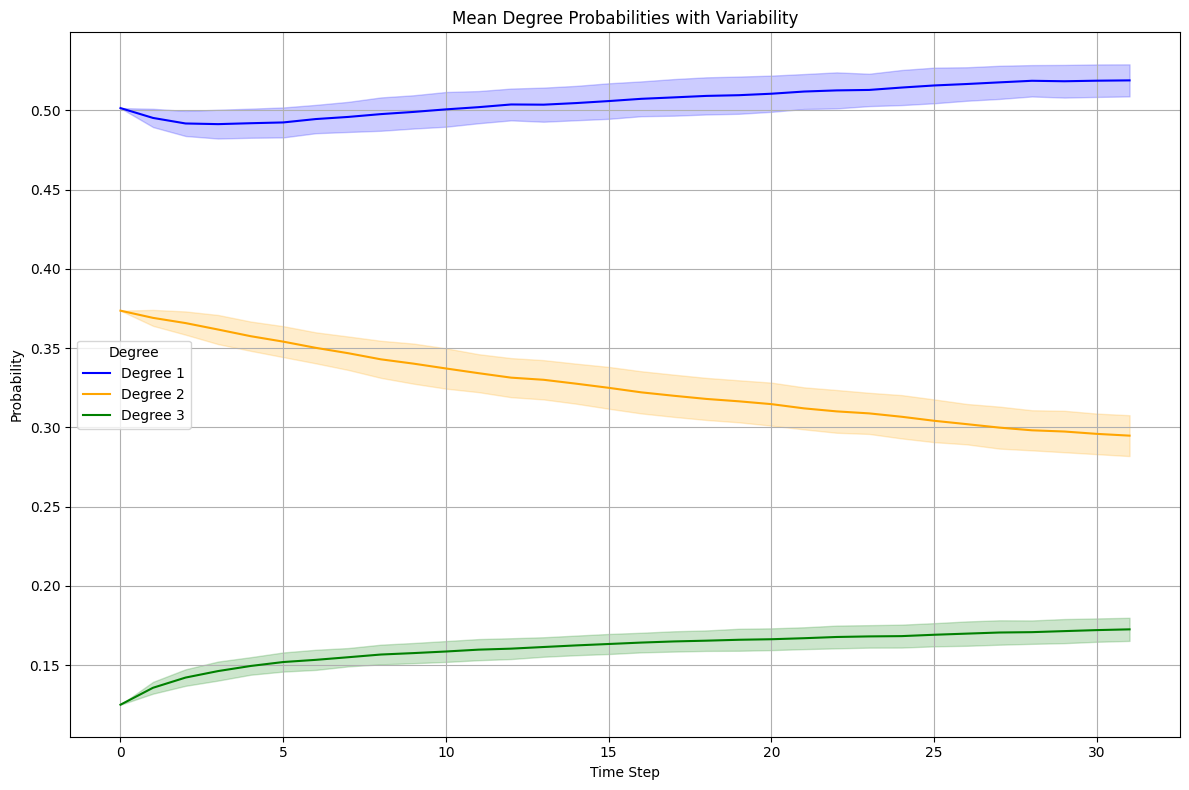

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import numpy as np

# File pattern
file_pattern = FILE_PATTERN
all_files = sorted(glob(file_pattern))

# Load and trim all dataframes
dfs = [pd.read_csv(f) for f in all_files]

# Extract just the values
degree1_all = np.array([df['Degree1_Prob'].values for df in dfs])
degree2_all = np.array([df['Degree2_Prob'].values for df in dfs])
degree3_all = np.array([df['Degree3_Prob'].values for df in dfs])

# Compute mean and std
degree_stats = {
    "Degree 1": (degree1_all.mean(axis=0), degree1_all.std(axis=0), 'blue'),
    "Degree 2": (degree2_all.mean(axis=0), degree2_all.std(axis=0), 'orange'),
    "Degree 3": (degree3_all.mean(axis=0), degree3_all.std(axis=0), 'green'),
}

# Reset time steps to 0–139
time_steps = range(len(degree1_all[0]))

# Plot
plt.figure(figsize=(12, 8))
for label, (mean, std, color) in degree_stats.items():
    plt.plot(time_steps, mean, color=color, label=label)
    plt.fill_between(time_steps, mean - std, mean + std, color=color, alpha=0.2)

plt.title("Mean Degree Probabilities with Variability")
plt.xlabel("Time Step")
plt.ylabel("Probability")
plt.grid(True)
plt.legend(title="Degree")
plt.tight_layout()
plt.show()
